# exp18_OCR

LMS실습과 미니프로젝트를 하나로 엮었음<br>


# exp18_ocr lms practice

# OCR [1] by 'Google API'

In [22]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [28]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/exp18_ocr/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME') + '/aiffel/exp18_ocr/cafe.jpeg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-r--r-- 1 root root 2337 Nov 25 00:56 /aiffel/aiffel/exp18_ocr/my_google_api_key.json


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #450860414869 by visiting https://console.developers.google.com/billing/enable?project=450860414869 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry.

# [1] OCR by 'kears_ocr'

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [ ]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4',
   'https://www.google.com/search?q=sign&rlz=1C5CHFA_enKR978KR978&sxsrf=AOaemvITulQeV2QrZPQCYsMkvko-764bsw:1638426464546&source=lnms&tbm=isch&sa=X&ved=2ahUKEwi1kKObvsT0AhXGFogKHcf6B0gQ_AUoAXoECAEQAw&biw=1440&bih=732&dpr=2#imgrc=lpFRHrJcRQQx1M'

]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

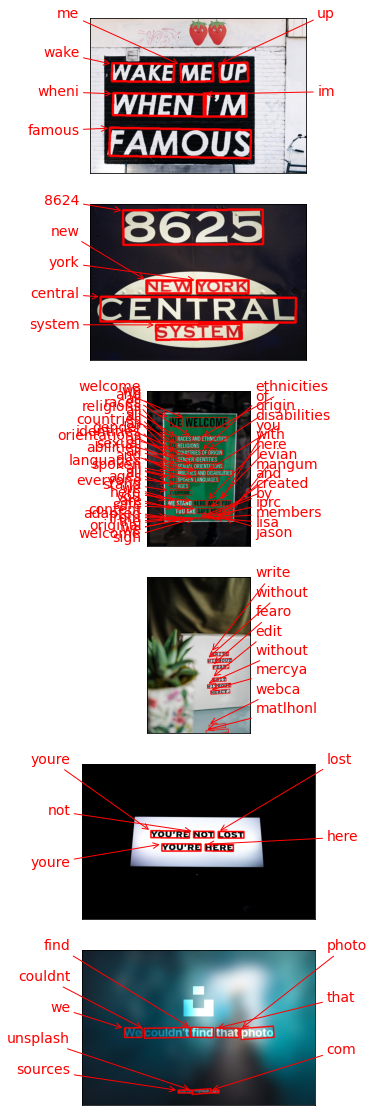

In [93]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# [3] OCR by 'tessearct'

In [14]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/exp18_ocr'
img_file_path = work_dir + '/cafe.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/exp18_ocr/0000.png


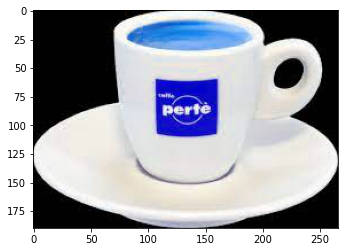

In [15]:
import cv2

img = cv2.imread('0000.png')
plt.imshow(img)
plt.show()

In [16]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

as

Done


# MinPRJ
> author : bae hueng myoung<br>
> date : 2 dec 2021

# overview 
ocr은 문자 인식 기술로써 매우 유용한 기능을 제공한다. 4차 산업 혁명과 디지털 트랜스폼에서 수기로 작성되거나 프린트된 문자들을 데이터베이스화 하는데 엄청난 인력과 비용이 소모된다. 한국의 지자체 공공기관에서는 인력으로 오래된 문서들을 스캔하고 데이터베이스화하는 작업을 거치고 있으며 이러한 장시간의 단순 반복작업들은 사람의 일과 적합하지 않다. 이번 lms에는 문자들을 인식할 수 있는 모델 Google OCR API, keras-ocr, Tesseract 3가지를 실습해보고 어떤 모델이 성능에 우위를 점하고 어떠한 결과를 나타내는지 알아볼 것이다. 

(google ocr api는 biling문제로 인하여 실습에서 제외하였다.)

# design purpose

문자를 인식하기 위해선 다양한 환경들이 존재한다. 손으로 쓴 편지, 광고의 표지판, 고속도로의 지역 이름 등 우리 사회에는 곳곳의 다양한 글, 이미지, 스타일들의 문자들로 넘쳐난다. 이러한 문자들을 인식하는 것은 사람에게 매우 쉽지만 기계들은 이를 잘 인지하기 어렵다. 특히 광고판과 같이 이미지의 다양한 특색이 가미되거나 상공의 드론들이 형성하는 문자들에 대해서는 기계가 이를 잘 인지하기 어렵다고 예상된다. 따라서 2가지모델에 대해서 다양한 특색을 갖는 이미지들을 불러와 어떠한 모델이 어떠한 인지능력을 갖는지 살펴볼 것이다.

## getting of img validation image files (20)

In [72]:
img_path = os.getenv('HOME') + '/aiffel/exp18_ocr/imgs/img'

img_file_path = []
for i in range(20):
    idx = i + 1
    img_file_path.append(img_path + str(idx) + '.jpeg')

img_file_path[0]


'/aiffel/aiffel/exp18_ocr/imgs/img1.jpeg'

In [73]:
img_file_path

['/aiffel/aiffel/exp18_ocr/imgs/img1.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img2.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img3.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img4.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img5.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img6.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img7.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img8.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img9.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img10.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img11.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img12.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img13.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img14.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img15.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img16.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img17.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img18.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img19.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img20.jpeg']

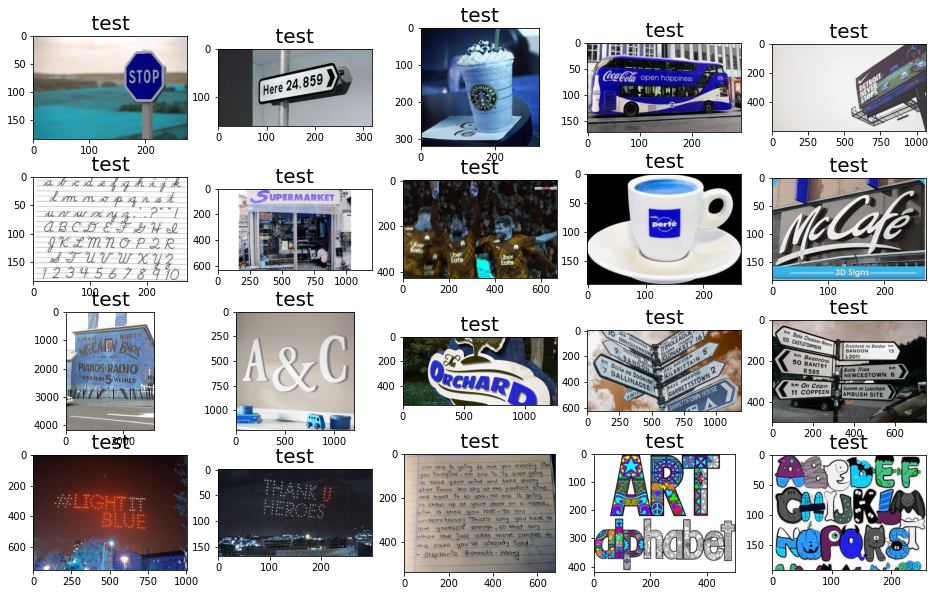

In [70]:
rows = 4
cols = 5

plt.figure(figsize=(16,10))
for i in range(20):
    plt.subplot(rows,cols,i+1)
    plt.imshow(cv2.imread(img_file[i]))
    plt.title(" test " , fontsize=20)

In [76]:
img_file = []
for i in range(20):
    img_file.append(cv2.imread(img_file_path[i]))
    
len(img_file)

20

In [106]:

images = [ keras_ocr.tools.read(url) for url in img_file_path]
prediction_groups = [pipeline.recognize([url]) for url in img_file_path]

# [1] KERAS OCR 

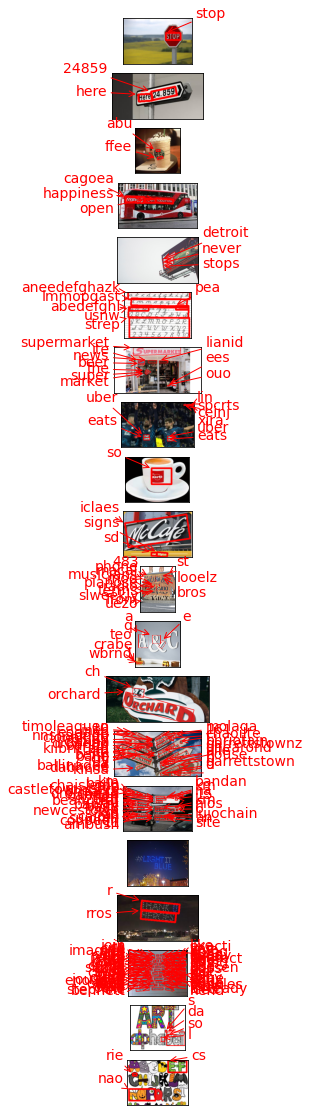

In [107]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

<AxesSubplot:>

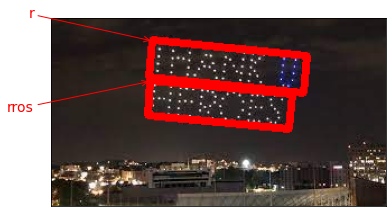

In [109]:
keras_ocr.tools.drawAnnotations(image=images[16], 
                                    predictions=prediction_groups[16][0])

<AxesSubplot:>

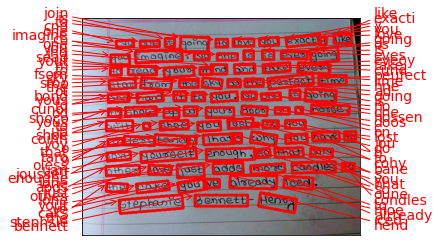

In [110]:
keras_ocr.tools.drawAnnotations(image=images[17], 
                                    predictions=prediction_groups[17][0])

#### keras OCR은 꽤 준수한 성능을 보여주고 있다. 표지판의 글자들은 매우 정확하게 인식하는 성과를 보여주고 있지만 컵과 같은 물체에 프린트된 비정형화의 이미지에 대해서는 성능이 좋지 않았다. 가장 텍스트의 모양에 거리가 멀다고 여겨지는 상공의 드론에 대해서 "THANK YOU"라는 알파벳을 인지하지 못하였다. 이는 keras ocr은 일반 문서작업환경에서 정형화된 작업에 매우 편리하게 이용할 수 있으나 펜과 컴퓨터 알파벳이 아닌 광고판, 드론의 모양 등에 대해서는 유연하게 인지하지 못하여 이용하기 어려워 보인다.

# [2] TESSERACT OCR

In [136]:
file_name = []
for i in range(20):
    file_name.append('/img'+ str(i+1)+'.jpeg')
file_name

['/img1.jpeg',
 '/img2.jpeg',
 '/img3.jpeg',
 '/img4.jpeg',
 '/img5.jpeg',
 '/img6.jpeg',
 '/img7.jpeg',
 '/img8.jpeg',
 '/img9.jpeg',
 '/img10.jpeg',
 '/img11.jpeg',
 '/img12.jpeg',
 '/img13.jpeg',
 '/img14.jpeg',
 '/img15.jpeg',
 '/img16.jpeg',
 '/img17.jpeg',
 '/img18.jpeg',
 '/img19.jpeg',
 '/img20.jpeg']

In [137]:
work_dir = os.getenv('HOME') + '/aiffel/exp18_ocr/imgs'
work_dir

'/aiffel/aiffel/exp18_ocr/imgs'

In [138]:
img_file_path = []
for i in range(20):
    img_file_path.append(work_dir + file_name[i])
img_file_path

['/aiffel/aiffel/exp18_ocr/imgs/img1.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img2.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img3.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img4.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img5.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img6.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img7.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img8.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img9.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img10.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img11.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img12.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img13.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img14.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img15.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img16.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img17.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img18.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img19.jpeg',
 '/aiffel/aiffel/exp18_ocr/imgs/img20.jpeg']

In [161]:
def tesseract(img_file_path,work_dir):
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
    print('###### recognized word #####')
    recognize_images(cropped_image_path_list)

    for i in range(len(cropped_image_path_list)):
        cropped_img = cv2.imread(cropped_image_path_list[i])
        plt.imshow(cropped_img)
        plt.show()

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####
& i

Done


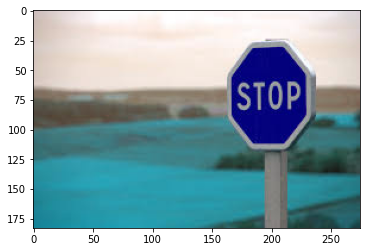

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####
Pe 94,859 ¥

Done


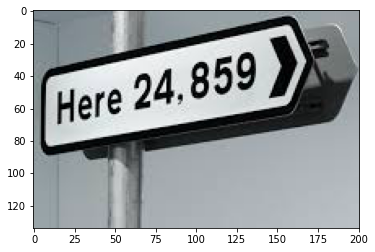

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####
me

Done


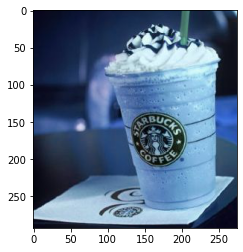

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####

Done


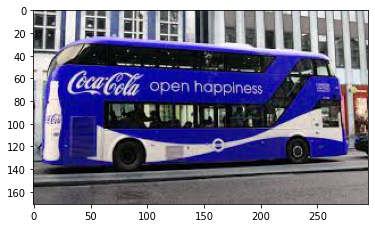

In [162]:
for i in range(4):
    tesseract(img_file_path[i], work_dir)

/aiffel/aiffel/exp18_ocr/imgs/0000.png
/aiffel/aiffel/exp18_ocr/imgs/0001.png
/aiffel/aiffel/exp18_ocr/imgs/0002.png
###### recognized word #####
aa ed 24

ghia yg mR


Done


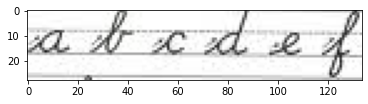

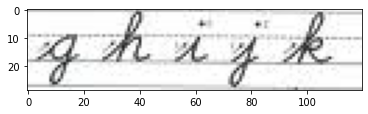

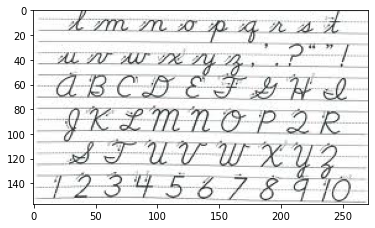

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####

Done


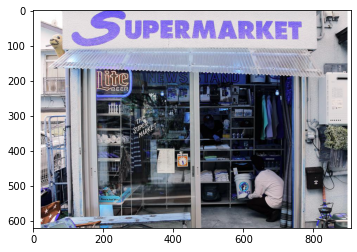

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####
s =

Done


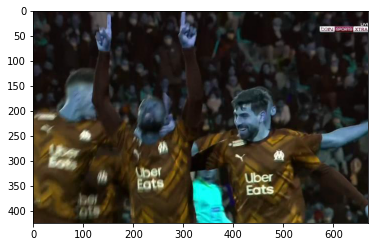

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####
as

Done


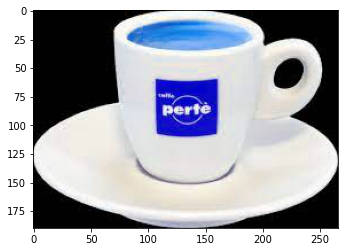

In [163]:
for i in range(4):
    tesseract(img_file_path[i+5], work_dir)

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####
oe

Done


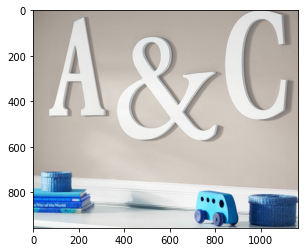

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####

Done


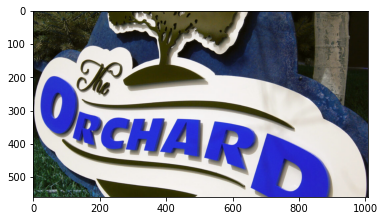

/aiffel/aiffel/exp18_ocr/imgs/0000.png
###### recognized word #####
ms

Done


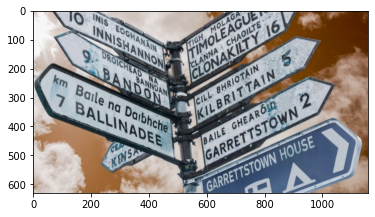

/aiffel/aiffel/exp18_ocr/imgs/0000.png
/aiffel/aiffel/exp18_ocr/imgs/0001.png
/aiffel/aiffel/exp18_ocr/imgs/0002.png
/aiffel/aiffel/exp18_ocr/imgs/0003.png
/aiffel/aiffel/exp18_ocr/imgs/0004.png
/aiffel/aiffel/exp18_ocr/imgs/0005.png
/aiffel/aiffel/exp18_ocr/imgs/0006.png
/aiffel/aiffel/exp18_ocr/imgs/0007.png
/aiffel/aiffel/exp18_ocr/imgs/0008.png
/aiffel/aiffel/exp18_ocr/imgs/0009.png
/aiffel/aiffel/exp18_ocr/imgs/0010.png
/aiffel/aiffel/exp18_ocr/imgs/0011.png
/aiffel/aiffel/exp18_ocr/imgs/0012.png
/aiffel/aiffel/exp18_ocr/imgs/0013.png
/aiffel/aiffel/exp18_ocr/imgs/0014.png
/aiffel/aiffel/exp18_ocr/imgs/0015.png
/aiffel/aiffel/exp18_ocr/imgs/0016.png
/aiffel/aiffel/exp18_ocr/imgs/0017.png
/aiffel/aiffel/exp18_ocr/imgs/0018.png
/aiffel/aiffel/exp18_ocr/imgs/0019.png
/aiffel/aiffel/exp18_ocr/imgs/0020.png
/aiffel/aiffel/exp18_ocr/imgs/0021.png
/aiffel/aiffel/exp18_ocr/imgs/0022.png
/aiffel/aiffel/exp18_ocr/imgs/0023.png
/aiffel/aiffel/exp18_ocr/imgs/0024.png
/aiffel/aiffel/exp18_ocr/

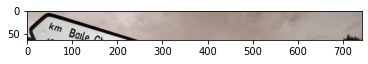

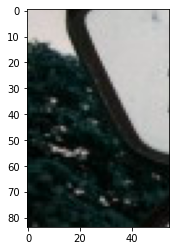

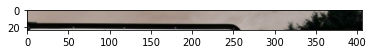

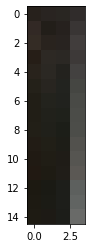

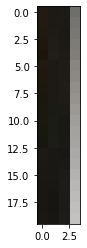

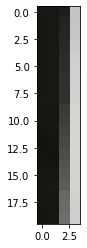

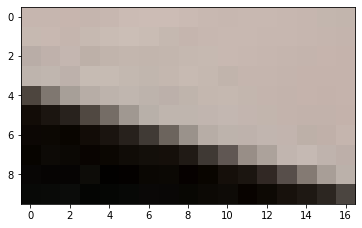

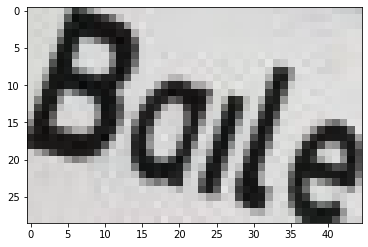

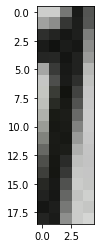

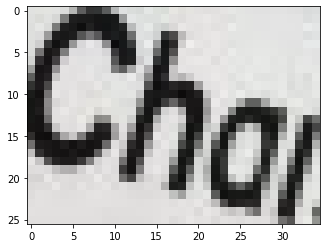

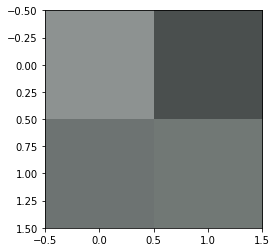

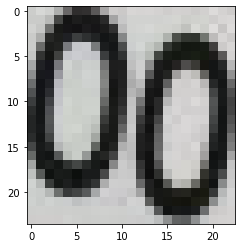

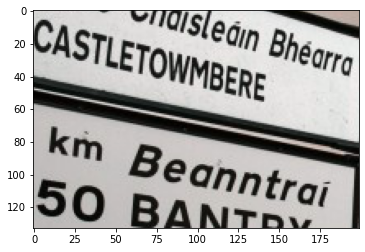

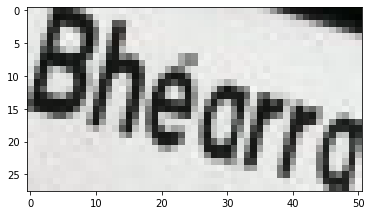

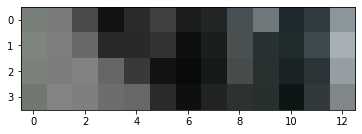

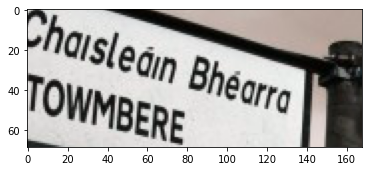

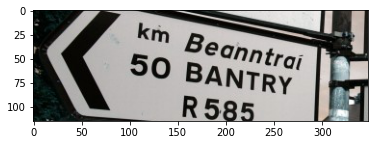

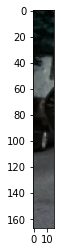

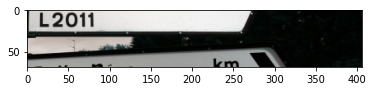

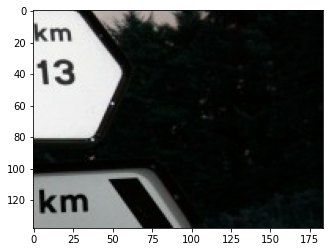

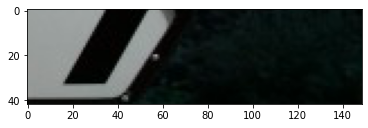

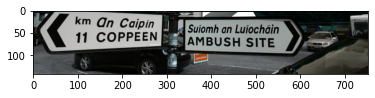

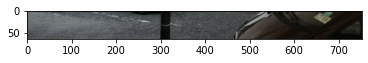

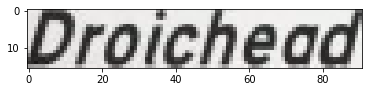

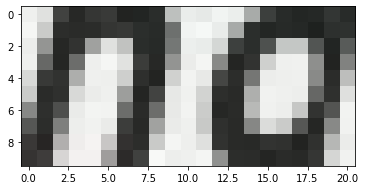

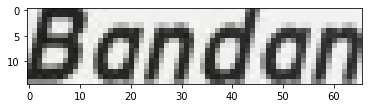

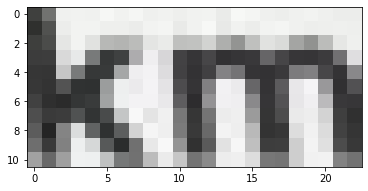

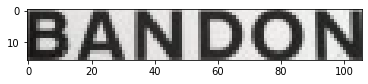

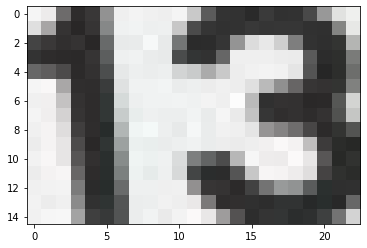

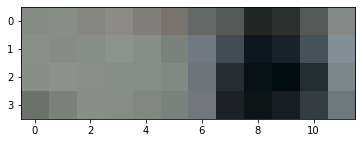

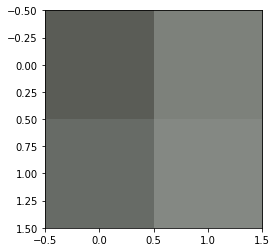

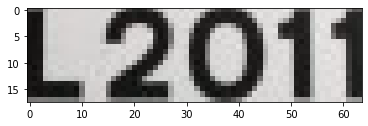

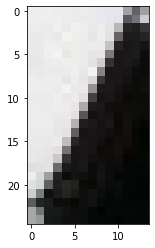

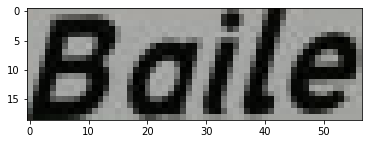

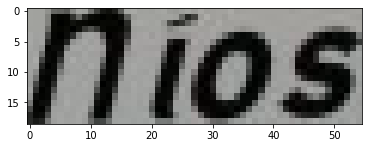

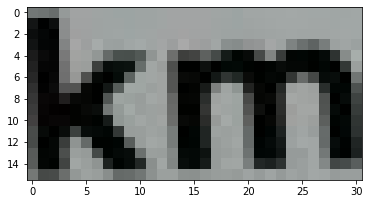

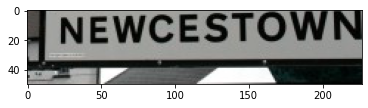

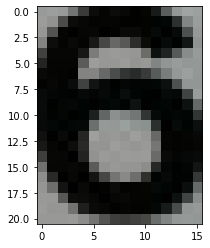

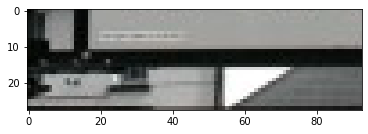

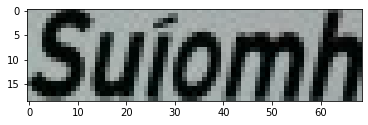

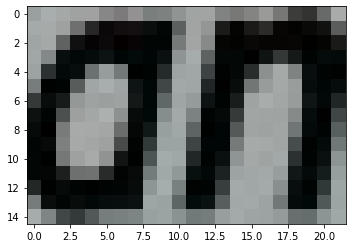

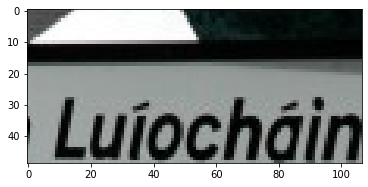

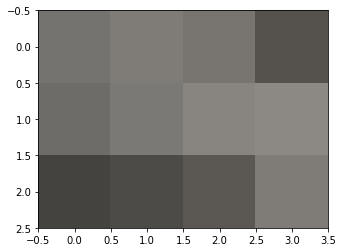

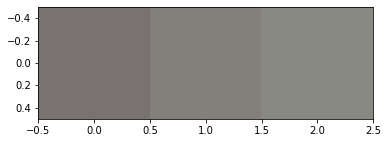

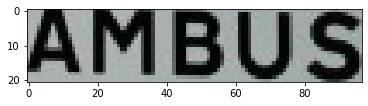

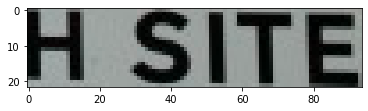

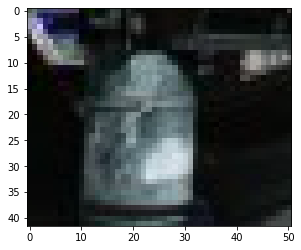

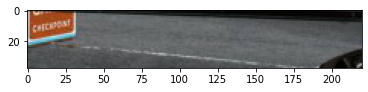

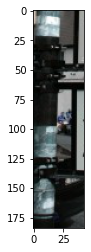

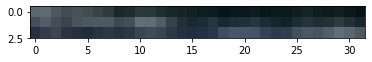

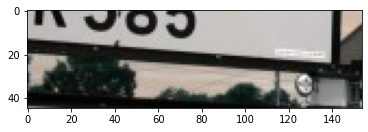

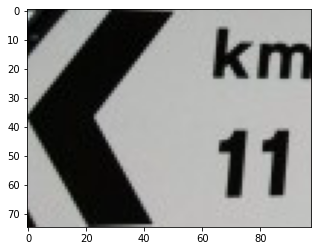

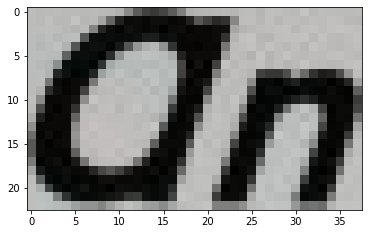

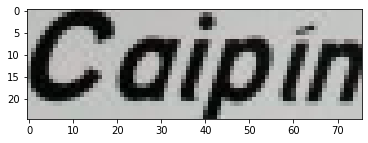

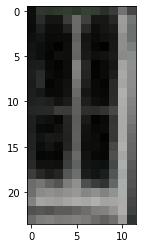

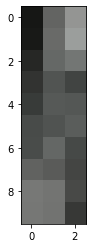

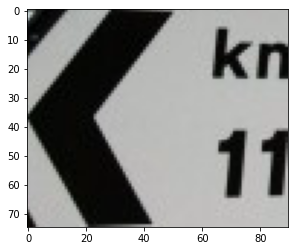

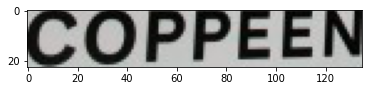

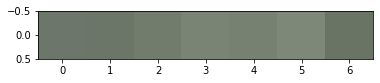

In [165]:
for i in range(4):
    tesseract(img_file_path[i+11], work_dir)


#### analysis : 테서렉트는 바운딩 박스를 통해 이미지의 위치를 crop하여 인지하는 2가지의 세분화된 과정을 거쳐 문자 인식에서 kears보다 섬세할 것으로 예상했었다. 하지만 tesseract의 결과는 위의 keras모델보다 ocr 퍼포먼스가 심히 떨어지는 모습을 보인다. 가장 ocr난이도가 가장 낮다고 여겨졌던 표지판의 프린팅 된 철자에 대해서도 정확한 인지를 하지 못한 결과를 나타내었다.

# In my opinion 

ocr을 이용하는데 있어서 여러 특색들이 가미된 문자들을 인지하는 것은 매우 어렵다. 기계가 실상 읽어낸다고 하여도 문자에 담긴 의미를 이해하는 것이 아니기 때문이다. 문자는 심벌(상징)의 이미지 도구로써 오랫동안 인류의 사고기술에 큰 이바지를 한 발명품이다. '나', '너', '하늘'과 같은 철자들은 하나의 이미지 형상이며 경험들을 함축해놓은 무형의 도구들이다. 이번 ocr에 대해서 성능이 기대만큼 크지 않았던 이유는 바로 "인지"에서 차이를 보였기 때문일 것으로 보인다. 